# CARDOS data processing

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [2]:
dto = '/storage/experiments/2022/0729_bourka_lhenice_CAR1/mox/cardos/'
dto = '/storage/experiments/2022/0819_bourka_strancice_CAR1/mox/cardos/'
dto = "/storage/experiments/2022/0826_bourka_staryvestec_CAR1/mox/cardos/"

fto = dto + 'CARDOS_CAR1_20220729_184845.log'
fto = dto + 'CARDOS_CAR1_20220826_143226.log'

l=[]
l.extend(range(0,1034))
#df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='c' )

df[1] = df[1].str.strip()

df.drop(df[df[1]=='$GPTXT'].index, inplace=True)
df.drop(df[df[1]=='$GPVTG'].index, inplace=True)
df.drop(df[df[1]=='$GPGLL'].index, inplace=True)
df.drop(df[df[1]=='$GPGSA'].index, inplace=True)
df.drop(df[df[1]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[1]=='$AIRDOS',4]
fw = df.loc[df[1]=='$AIRDOS',2]
last = df.loc[df[1]=='$AIRDOS'].index
print ('s.n.: ',sn[2])
print ('f.v.: ',fw[2])
print(df.loc[df[1]=='$AIRDOS',1])
print(len(df))
print(last[-1:][0])

df['UTC']=pd.to_datetime(df[0].astype(str), format='%Y%m%d_%H%M%S.%f')

#df.set_index('time', inplace=True)
df.drop(columns=0, inplace=True)
df.columns = range(df.columns.size)
df = df.rename(columns={1033: 'UTC'})

df['meas'] = df.index
#df['meas'] = df.loc[df[0]=='$HIST',1]
df.loc[df[0]=='$HITS','meas'] = np.nan
df = df.fillna(method='ffill')
df.meas = df.meas.astype(int)

# keep only last run
#df.drop(df.index[:last[-1:][0]], inplace=True) 

s.n.:  1290c00806a200915013a000a000000c
f.v.:  CAR_1024_v0
2    $AIRDOS
Name: 1, dtype: object
2652
2


In [3]:
#df.loc[df[0]=='$GNRMC'][-5:]
df

,0,1,2,3,4,5,6,7,8,9,...,1025,1026,1027,1028,1029,1030,1031,1032,UTC,meas
0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-26 14:32:27.672521,0
1,#Hmmm...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-26 14:32:28.192206,1
2,$AIRDOS,CAR_1024_v0,NaI(Tl)-D16x30,1290c00806a200915013a000a000000c,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-26 14:32:28.208428,2
3,$GNRMC,143225.00,A,5006.99583,N,01427.66456,E,0.835,NaN,260822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-26 14:32:29.924759,3
4,$GNVTG,143225.00,T,5006.99583,M,0.835,N,1.547,K,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-26 14:32:29.925069,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2735,$HITS,10,16274,82,24947,126,39200,125,46220,69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-26 18:11:22.620013,2734
2736,$HIST,1125,13149.10,98933.25,21.69,79,0,4181,30197,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-26 18:11:34.270374,2736
2737,$HITS,14,3083,97,3722,64,9968,142,25639,411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-26 18:11:34.270841,2736
2738,$HIST,1126,13160.75,98935.50,21.69,82,0,3522,30851,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-26 18:11:45.918870,2738


## Add individual events to histogram

In [13]:
NOISECH = 3
HISTHITS = 60 - NOISECH
FIRSTCH = 9

df.dropna(subset=['UTC'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:FIRSTCH+HISTHITS].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric) #,errors='coerce')
#hist[0] = df[0]
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
#hist.iloc[:,18:269] = 0
hist.set_index('meas', inplace=True)

hits = df.loc[df[0]=='$HITS'].copy()
#hits['meas'] = hist.index
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits['UTC'] = df['UTC']
hits.set_index('meas', inplace=True)


In [14]:
hits.loc[hits[1]>500,1]=500
hitsend = len(hits.columns)
print(hitsend)
hits.loc[:,[*map('h{:04}'.format, range(1050))]] = 0
try:
    for i in range(len(hits)):
        for j in range(hits.iloc[i,1]):
            hits.iloc[i,int(hitsend+hits.iloc[i,j*2+3])] +=1
except:
    print(i,j)
    raise
            
histogram = hist.iloc[:,FIRSTCH:FIRSTCH+HISTHITS].copy()
histogram = histogram.join(hits.iloc[:,hitsend+NOISECH+HISTHITS:])
hist = hist.rename(columns={4: 'temperature', 3: 'pressure'})
histogram = histogram.join(hist[['pressure','temperature','UTC']])

histogram = histogram.rename(columns={x:y for x,y in zip(histogram.columns[:1024],range(0,1024))})
histogram[:5]
#histogram.to_csv(dto + '/histogram.csv')

1034


,0,1,2,3,4,5,6,7,8,9,...,h1043,h1044,h1045,h1046,h1047,h1048,h1049,pressure,temperature,UTC
meas,,,,,,,,,,,,,,,,,,,,,
24,6,5,5.0,3,5,7.0,3.0,4.0,3.0,2.0,...,0,0,0,0,0,0,0,98297.00,29.13,2022-08-26 14:32:41.637980
26,7,3,5.0,4,2,1.0,9.0,7.0,0.0,4.0,...,0,0,0,0,0,0,0,98295.50,29.13,2022-08-26 14:32:53.277532
28,7,3,3.0,3,3,2.0,5.0,2.0,2.0,3.0,...,0,0,0,0,0,0,0,98300.75,29.13,2022-08-26 14:33:04.922540
30,7,4,5.0,6,3,5.0,3.0,2.0,6.0,2.0,...,0,0,0,0,0,0,0,98329.50,29.19,2022-08-26 14:33:16.567832
32,10,7,12.0,2,3,4.0,1.0,4.0,3.0,5.0,...,0,0,0,0,0,0,0,98326.75,29.19,2022-08-26 14:33:28.211095


## Plot Flux

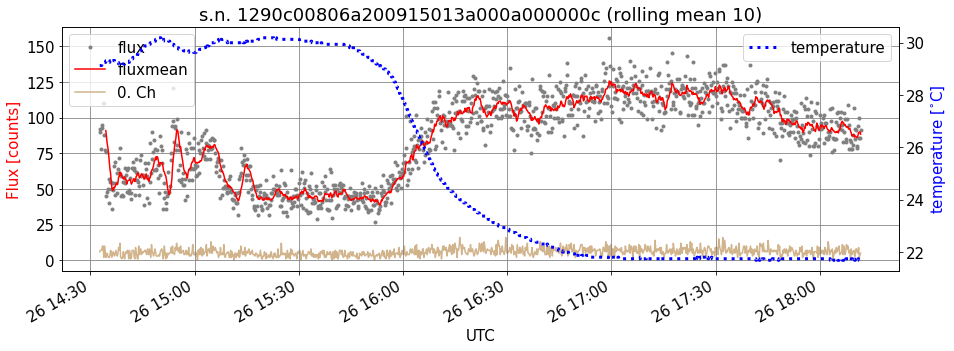

In [15]:
NOISE_LEVEL = 0
LAST_CHANNEL = 1023
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#histogram.read_csv(dto + '/histogram.csv')
xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#xx = xx.loc['2022-1-1 00:00:00':'2022-2-1 00:00:00']
#xx = xx.loc['2022-2-13 00:00:00':'2022-2-22 00:00:00']
#xx = xx.loc['2022-4-25 00:00:00':'2022-4-25 8:00:00']
#xx = xx.loc['2022-1-16 00:00:00':'2022-1-21 00:00:00']
#xx = xx.loc['2021-11-17 00:00:00':'2021-11-18 00:00:00']
#xx = xx.loc['2022-07-17 00:00:00':'2022-07-17 19:50:00']
#xx = xx.loc['2022-07-17 20:00:00':'2022-07-17 23:50:00']

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + sn[2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,350])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=2)
plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-post')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.legend()



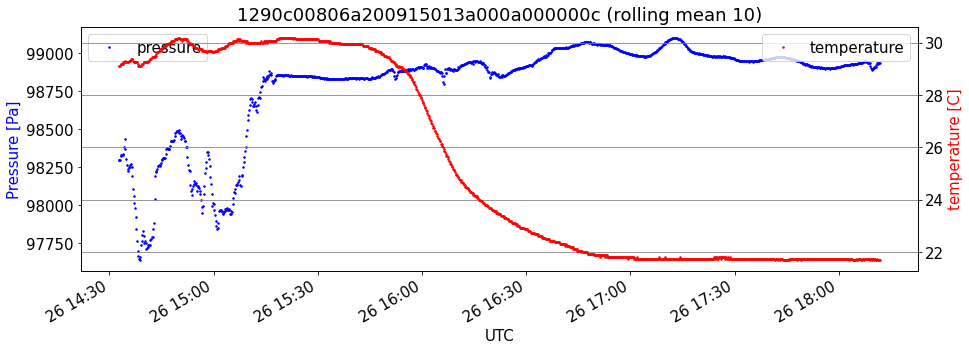

In [16]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx['pressure'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(sn[2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')
plt.legend()



# Blitzortung

In [135]:
import json
from json import JSONDecodeError
import urllib3

#lat=49.0640992 # Polednik
#lon=13.3950208

lat=49.0078642 # Trebon
lon=14.7379117

lat=50.1702058 # dalnice na KV
lon=13.7393756

start=pd.Timestamp('2022-05-20 19:11:38')
end=pd.Timestamp('2022-05-20 19:11:40')

BLITZ_DIST = 100      

print(start, end, lat, lon)

### url for json data preparation
url=[]

region=1
for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))
region=18
for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))
region=19
for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))


blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        #html = requests.get(url[i]).content
        html = requests.get(url[i])
        print(url[i])

        htmlx = html.text.replace("}{", "},{" )
        blitz_part = pd.read_json(htmlx,lines=True)
        #blitz=blitz.append(blitz_part)
        blitz = pd.concat([blitz,blitz_part])
        #html = requests.get(url[i])
        #blitz_part = pd.read_json(html,lines=True)
        #blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 

    except:
        print("No data", url[i])
        pass
blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-2) )&(blitz['lat']<(lat+2) )]
blitz=blitz[(blitz['lon']>(lon-3.5) )&(blitz['lon']<(lon+3.5) )]

### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
    pass
#blitz['time']=blitz.index    
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)
try:
    blitz.drop(columns=['sig'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
blitz = blitz.loc[blitz['km'] < BLITZ_DIST]
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
#blitz.reset_index(inplace=True)
#blitz.set_index('date', inplace=True)

#blitz.to_csv(dto + "/blitz.csv")

print('end')

2022-05-20 19:11:38 2022-05-20 19:11:40 50.1702058 13.7393756
http://data.blitzortung.org/Data/Restricted/Strikes_1/2022/05/20/19/10.json
http://data.blitzortung.org/Data/Restricted/Strikes_1/2022/05/20/19/20.json
http://data.blitzortung.org/Data/Restricted/Strikes_18/2022/05/20/19/10.json
http://data.blitzortung.org/Data/Restricted/Strikes_18/2022/05/20/19/20.json
http://data.blitzortung.org/Data/Restricted/Strikes_19/2022/05/20/19/10.json
http://data.blitzortung.org/Data/Restricted/Strikes_19/2022/05/20/19/20.json
end


/tmp/ipykernel_20400/3373555705.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  xx = blitz['2022-05-20 19:11:37':'2022-05-20 19:11:41']


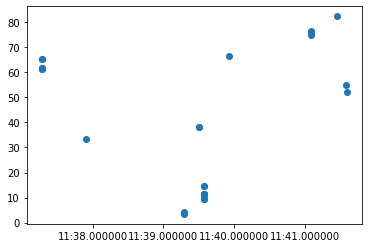

In [137]:
xx = blitz['2022-05-20 19:11:37':'2022-05-20 19:11:41']
plt.plot(xx.index,xx['km'], marker='o', linestyle='')

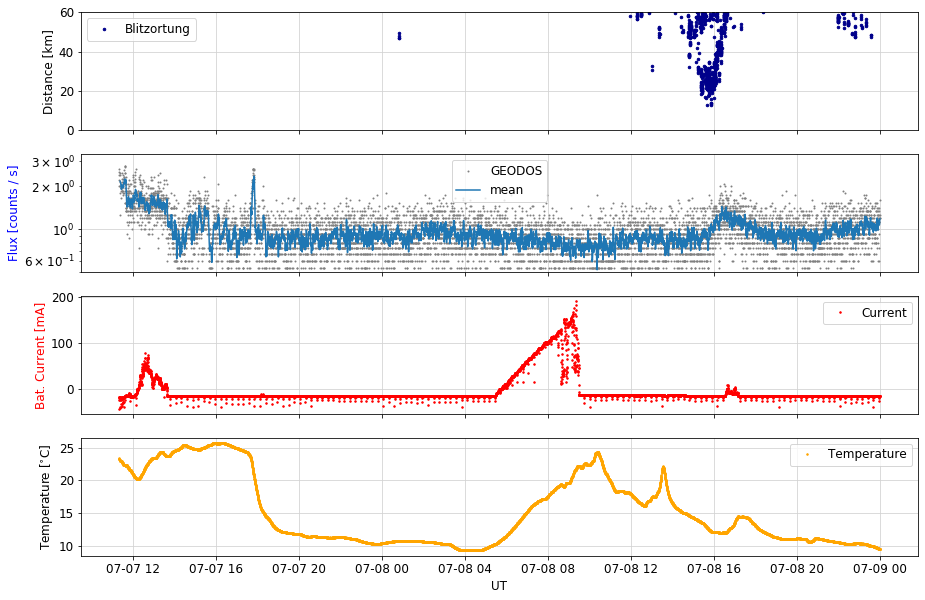

In [52]:
WINDOW = 10

FROM = '2021-07-07 00:00:00'
TO = '2021-07-09 00:00:00'

blitz = pd.read_csv(dto + "/blitz.csv")
blitz['date'] = pd.to_datetime(blitz['date'])
blitz.set_index('date', inplace=True)

fig, (ax6, ax3, ax5, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(15,10))
matplotlib.rcParams.update({'font.size': 12})

xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']
xx = xx.loc[FROM:TO]

blitzblitz = blitz.loc[FROM:TO]

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=2, linestyle='none')
ax3.plot(xx['fluxmean']/15, label='mean')
ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]', color='blue')
ax3.set_yscale('log')
ax3.set_ylim(0.5,)
ax3.legend()

ax4.plot(xx['temperature'], c='orange', label='Temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Temperature [$^{\circ}$C]')
ax4.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax4.legend()

ax6.plot(blitzblitz.index, blitzblitz.km, ls='', marker='.', ms=5, label='Blitzortung', c='darkblue')
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax6.set_ylim(0,60)

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax5.legend()


# Energy Spectrum

/tmp/ipykernel_18675/3564471910.py:25: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,2e4])


(0.6437910419977583, 20000.0)

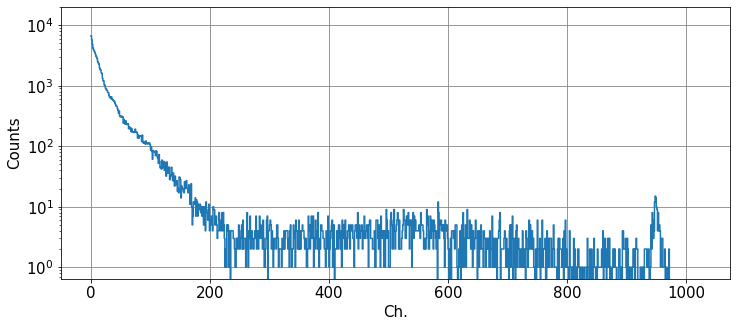

In [18]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

#yy = yy.loc['2021-08-15 11:00:00':'2021-08-16 18:00:00']
#yy = yy.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
#yy = yy.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#yy = yy.loc['2021-07-08 17:00:00':'2021-07-08 18:00:00']
#yy = yy.loc['2022-1-17 17:39:00':'2022-1-17 17:45:00']
#yy = yy.loc['2022-4-21 16:00:00':'2022-4-22 02:00:00']

#yy = yy.loc['2021-05-12 11:20:00':'2021-05-12 11:30:00']
#yy = yy.loc['2021-05-12 13:58:00':'2021-05-12 14:20:00']

#yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:1024],range(0,1024))})
ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([32,280])
plt.ylim([0,2e4])

(0.0, 4.0)

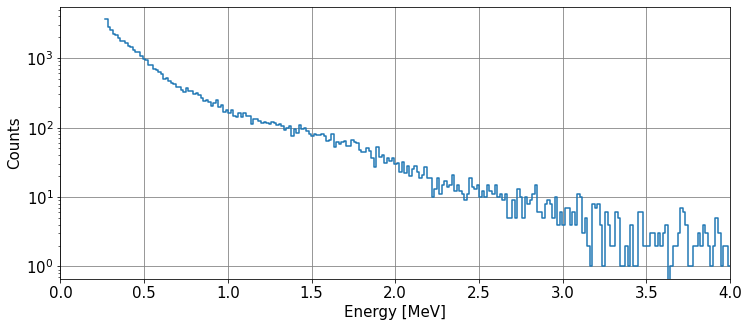

In [194]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

#yy = yy.loc['2021-08-15 11:00:00':'2021-08-16 18:00:00']
#yy = yy.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
#yy = yy.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#yy = yy.loc['2021-07-08 17:00:00':'2021-07-08 18:00:00']

#yy = yy.loc['2022-1-17 17:35:00':'2022-1-17 17:45:00']

#yy = yy.loc['2021-05-12 11:20:00':'2021-05-12 11:30:00']
#yy = yy.loc['2021-05-12 13:58:00':'2021-05-12 14:20:00']

#yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:1024],range(0,1024))})
ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()
ener['ener'] = 0.015 * ener.index + 0.268 

plt.figure(figsize=(12,5))
plt.plot(ener['ener'], ener[0], drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
plt.xlim([0,4])
#plt.ylim([0,250])

In [17]:
ener['ener'] = 0.015 * ener.index + 0.268 


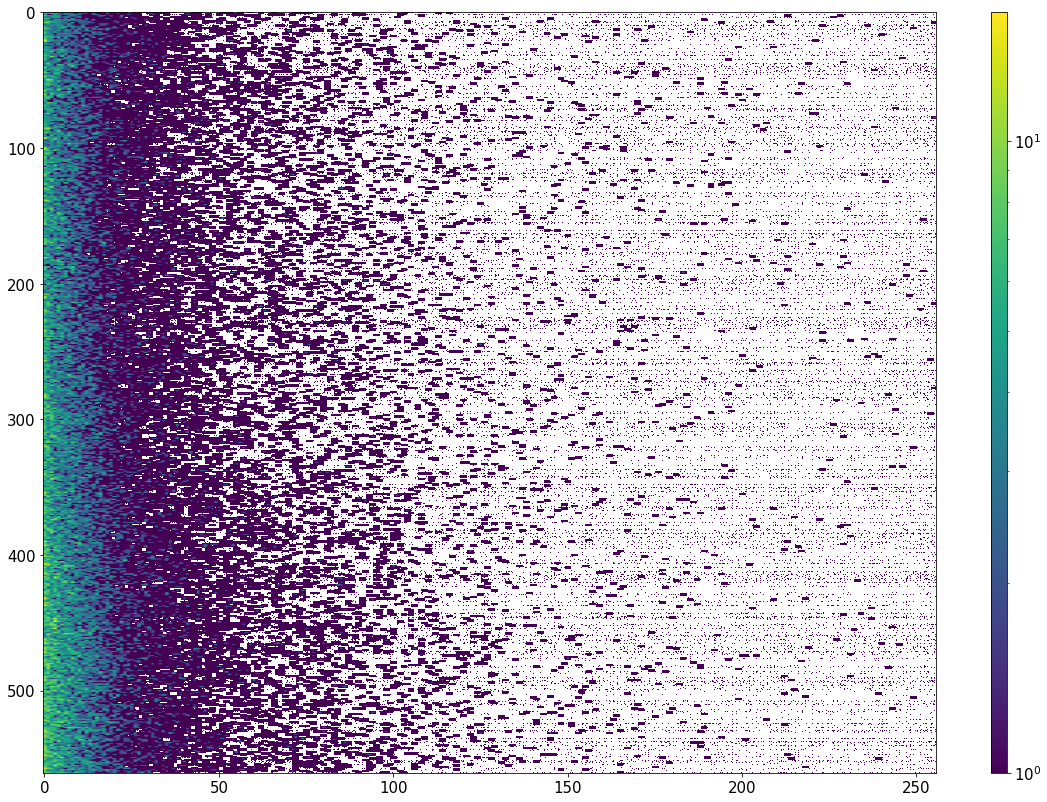

In [184]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 14))
plt.imshow((histogram.iloc[:,0:256]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None

(0.0, 300.0)

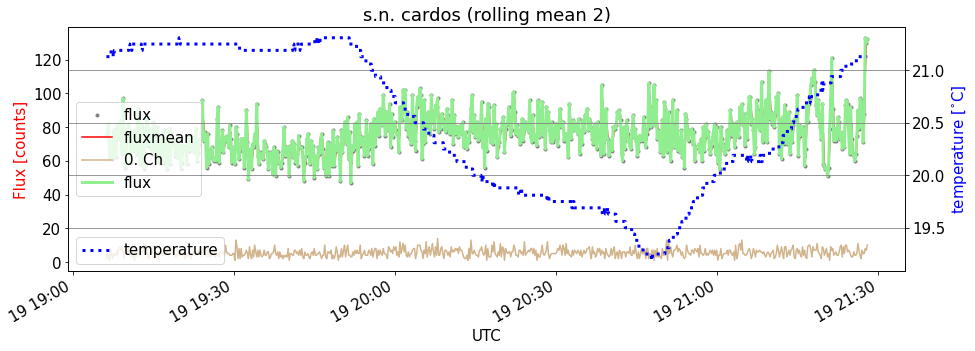

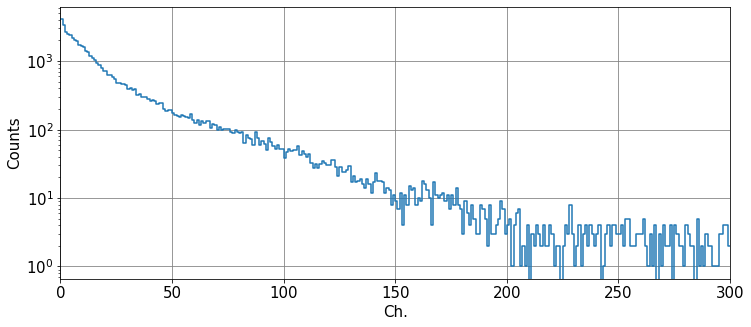

In [6]:
NOISE_LEVEL = 0
LAST_CHANNEL = 1023
WINDOW = 2

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#histogram.read_csv(dto + '/histogram.csv')
xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#xx = xx.loc['2021-05-12 8:35:00':'2021-05-12 16:00:00']
#xx = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
#yy = xx.loc['2021-05-12 11:05:00':'2021-05-12 11:30:00']
#yy = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
yy = xx

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)
yy['flux'].plot(c='lightgreen', linewidth='3')

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=6)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')
plt.legend()

yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,0:1023].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
plt.xlim([0,300])

In [188]:
l = np.array([[1, 1],[5,1]]) # Calibration
r = np.array([0.511, 1.275])
coef = np.linalg.solve(l,r)
print (coef[0], coef[1])
255  * coef[0] + coef[1]

0.19099999999999998 0.32


49.02499999999999